# Daten einlesen und Pipeline definieren

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ Adjusted R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def add_features(df):
    df['Jahr'] = df['Datum'].dt.year
    df['Monat'] = df['Datum'].dt.month
    df['Wochentag'] = df['Datum'].dt.weekday
    df['Kalenderwoche'] = df['Datum'].dt.isocalendar().week
    df['Tag_im_Jahr'] = df['Datum'].dt.dayofyear
    df['Ist_Wochenende'] = df['Wochentag'].isin([5, 6]).astype(int)
    df['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Monat_sin'] = np.sin(2 * np.pi * df['Monat'] / 12)
    df['Monat_cos'] = np.cos(2 * np.pi * df['Monat'] / 12)
    df['Wochentag_sin'] = np.sin(2 * np.pi * df['Wochentag'] / 7)
    df['Wochentag_cos'] = np.cos(2 * np.pi * df['Wochentag'] / 7)
    return df

def preprocess_data(df):
    df['Datum'] = pd.to_datetime(df['Datum'])
    df = add_features(df)
    df['Wettercode'] = df['Wettercode'].astype(str)
    df['KielerWoche'] = df['KielerWoche'].fillna(False).astype('bool')
    return df

# Load datasets

# Basisdatenset
df1 = pd.read_csv('../umsatzdaten_gekuerzt.csv')
# Wetterdaten
df2 = pd.read_csv('../wetter.csv')
# Kielerwocher
df3 = pd.read_csv('../kiwo.csv')
# Feiertage, Brückentage, Ferien
df4 = pd.read_csv('../Feier_Bruecke_Ferien_bis2018.csv')
# Verbraucherpreisindex
df5 = pd.read_csv('../VPI.csv')
# Erzeugerpreisindex
df6 = pd.read_csv('../EPI.csv')
# Heimspiele Holstein Kiel
df7 = pd.read_csv('../Heimspiel_Holstein_Kiel_finle.csv')
# Kieler Umschlag (kleineres Fest in Kiel)
df8 = pd.read_csv('../Kieler_Umschlag_finale.csv')
# Schulferien Litauen
df9 = pd.read_csv('../Schulferien_Litauen_finale.csv')

# Merge datasets
df = df1.merge(df2, on='Datum', how='left')
df = df.merge(df3, on='Datum', how='left')
df = df.merge(df4, on='Datum', how='left')
df = df.merge(df5, on='Datum', how='left')
df = df.merge(df6, on='Datum', how='left')
df = df.merge(df7, on='Datum', how='left')
df = df.merge(df8, on='Datum', how='left')
df = df.merge(df9, on='Datum', how='left')


missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)
# Preprocess data
df = preprocess_data(df)

# Define feature groups
numeric_features = ['Temperatur', 'Bewoelkung','HeimspielHK', 'KielerUmschlag', 'Windgeschwindigkeit', 'Tag_im_Jahr_sin', 'Tag_im_Jahr_cos', 'Monat_sin', 'Monat_cos', 'Wochentag_sin', 'Wochentag_cos', 'feiertag', 'KielerWoche', 'brueckentag', 'BW', 'BY', 'B', 'BB', 'HB', 'HH', 'HE', 'MV', 'NI', 'NW', 'RP', 'SL', 'SN', 'ST', 'SH', 'TH', 'VPI_brot_getreide', 'VPI_molkerei_ei', 'VPI_speiseoel_fett', 'VPI_Obst', 'VPI_zucker_suesses', 'EPI_teig', 'EPI_wasser', 'EPI_strom', 'EPI_fernwaerme', 'Herbstferien_LI', 'Weihnachtsferien_LI', 'Winterferien_LI', 'Fruehlingsferien_LI', 'Sommerferien_LI']
categorical_features = ['Warengruppe', 'Wettercode', 'Wochentag']



# Define ColumnTransformer
wettercode_categories = [str(i) for i in range(0, 100)] + ['Unbekannt']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), [feature for feature in numeric_features if feature != 'KielerWoche']),
        ('kielerwoche', SimpleImputer(strategy='constant', fill_value=0), ['KielerWoche']),
        ('wettercode', OneHotEncoder(categories=[wettercode_categories], handle_unknown='ignore'), ['Wettercode']),
        ('warengruppe', OneHotEncoder(handle_unknown='ignore'), ['Warengruppe']),
        ('wochentag', OneHotEncoder(handle_unknown='ignore'), ['Wochentag'])
    ],
    remainder='drop'
)
# Ensure 'KielerWoche' is int after preprocessing
df['KielerWoche'] = df['KielerWoche'].astype(int)

# Split data
train_end_date = '2017-07-31'
train_data = df[df['Datum'] <= train_end_date]
test_data = df[df['Datum'] > train_end_date]

X_train = train_data.drop(['Umsatz'], axis=1)
y_train = train_data['Umsatz']
X_test = test_data.drop(['Umsatz'], axis=1)
y_test = test_data['Umsatz']
X = df.drop(['Umsatz'], axis=1)
y = df['Umsatz']



Bewoelkung               70
Temperatur               16
Windgeschwindigkeit      16
Wettercode             2325
KielerWoche            9111
dtype: int64


# Correlation Matrix

In [39]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

print(corr_matrix['Umsatz'].sort_values(ascending=False))

Umsatz                 1.000000
Sommerferien_LI        0.231082
Temperatur             0.222935
NW                     0.193754
BB                     0.185120
B                      0.183774
TH                     0.183471
RP                     0.183448
MV                     0.180764
SH                     0.175640
ST                     0.171530
SL                     0.166413
HE                     0.164913
SN                     0.163594
NI                     0.163162
Ist_Wochenende         0.163097
HB                     0.162725
BW                     0.155330
HH                     0.148356
Wochentag              0.136199
BY                     0.131208
EPI_fernwaerme         0.095317
KielerWoche            0.058244
feiertag               0.050638
HeimspielHK            0.042073
Weihnachtsferien_LI    0.030706
Wochentag_cos          0.024867
brueckentag            0.018589
Tag_im_Jahr            0.015356
Windgeschwindigkeit    0.014705
Monat                  0.013889
EPI_teig

# Linear Regression

In [45]:

# Train and evaluate models
pipeline_lr = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])

# Exclude 'Datum' and 'id' from the feature set
X_train = X_train.drop(['Datum', 'id',], axis=1)
X_test = X_test.drop(['Datum', 'id'], axis=1)

# Train the model with the updated feature set
pipeline_lr.fit(X_train, y_train)
lr_y_pred = pipeline_lr.predict(X_test)
print("R² on test (LR):", r2_score(y_test, lr_y_pred))
print("adjusted R² on test (LR):", adjr2(y_test, lr_y_pred, len(df), df.drop(['Umsatz'], axis=1).shape[1]))

R² on test (LR): 0.7105740112371923
adjusted R² on test (LR): 0.7089210395341289


In [42]:
# Zugriff auf das trainierte Modell in der Pipeline
model = pipeline_lr.named_steps['model']

# Extrahieren der Koeffizienten und des Interzepts
coefficients = model.coef_
intercept = model.intercept_

# Variablennamen (entsprechen den Spaltennamen von X_train)
feature_names = X_train.columns

# Modellgleichung ausgeben
print("Modellgleichung:")
equation = f"y = {intercept:.3f}"  # Interzept
for coef, name in zip(coefficients, feature_names):
    equation += f" + ({coef:.3f} * {name})"
print(equation)

Modellgleichung:
y = 191.351 + (-1.222 * Warengruppe) + (-2.582 * Bewoelkung) + (-0.127 * Temperatur) + (-0.044 * Windgeschwindigkeit) + (-1.770 * Wettercode) + (9.489 * KielerWoche) + (-25.288 * feiertag) + (-14.083 * brueckentag) + (9.880 * BW) + (-18.578 * BY) + (2.864 * B) + (5.441 * BB) + (1.366 * HB) + (2.585 * HH) + (0.919 * HE) + (-1.781 * MV) + (2.837 * NI) + (-0.522 * NW) + (4.147 * RP) + (-0.322 * SL) + (8.633 * SN) + (-0.522 * ST) + (5.964 * SH) + (8.151 * TH) + (-1.571 * VPI_brot_getreide) + (0.663 * VPI_molkerei_ei) + (5.322 * VPI_speiseoel_fett) + (-1.819 * VPI_Obst) + (3.965 * VPI_zucker_suesses) + (-3.274 * EPI_teig) + (1.754 * EPI_wasser) + (-4.911 * EPI_strom) + (-3.745 * EPI_fernwaerme) + (-4.203 * HeimspielHK) + (-2.093 * KielerUmschlag) + (-8.211 * Herbstferien_LI) + (7.538 * Weihnachtsferien_LI) + (0.058 * Winterferien_LI) + (-2.192 * Fruehlingsferien_LI) + (1.791 * Sommerferien_LI) + (2.740 * Jahr) + (-1.498 * Monat) + (3.026 * Wochentag) + (36.790 * Kalenderwoc

# RandomForestRegressor

In [31]:
pipeline_rf = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
pipeline_rf.fit(X_train, y_train)
rf_y_pred = pipeline_rf.predict(X_test)
print("R² on test (RF):", r2_score(y_test, rf_y_pred))
print("adjusted R² on test (RF):", adjr2(y_test, rf_y_pred, len(df), df.drop(['Umsatz'], axis=1).shape[1]))


R² on test (RF): 0.8718758356244185
adjusted R² on test (RF): 0.871241216095908


# Evaluation LR vs RF

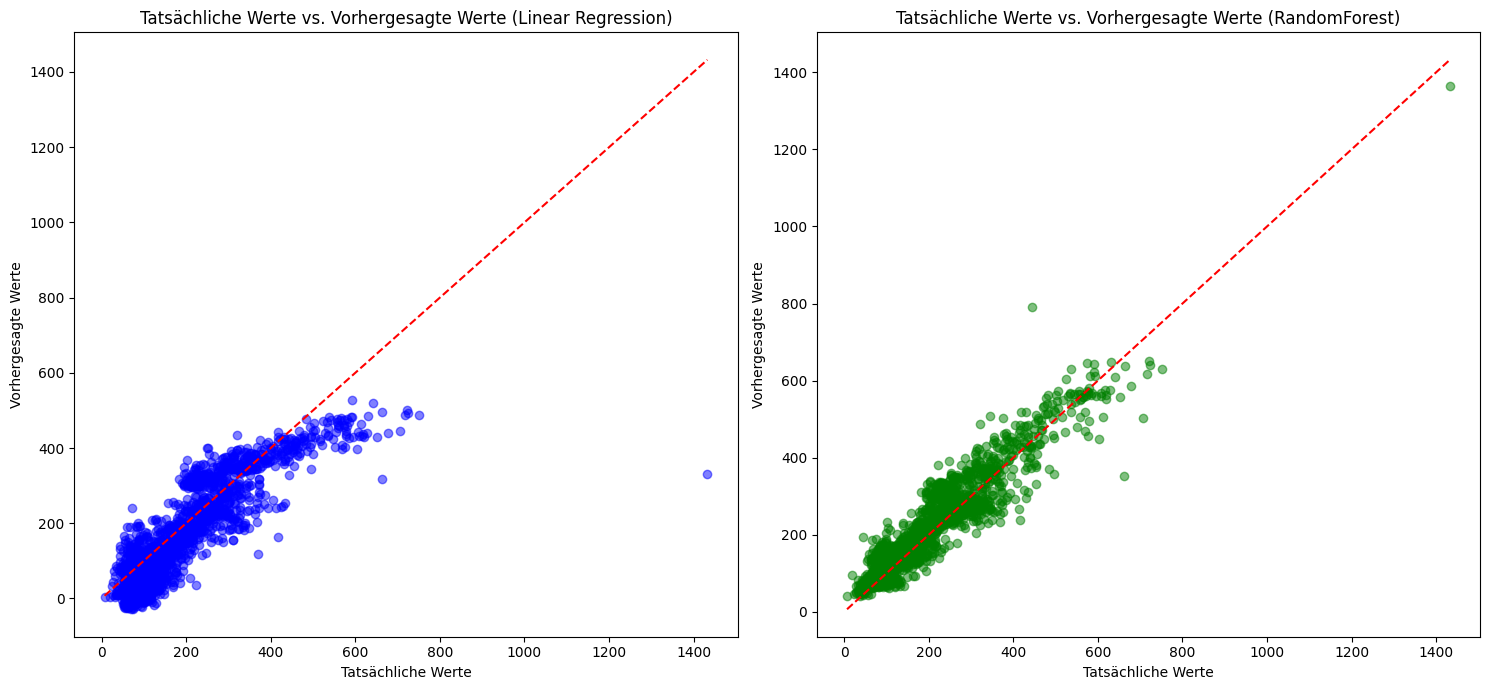

Text(0.5, 1.0, 'Residualplot (RandomForest)')

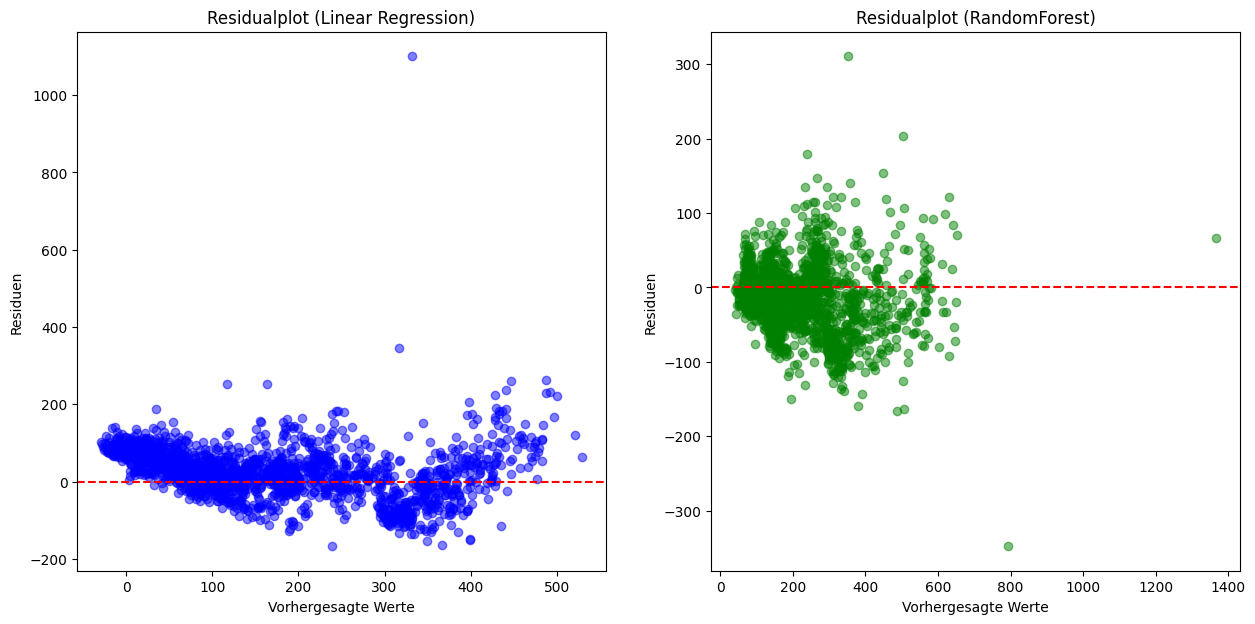

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# Flatten y_pred
lr_y_pred_flat = lr_y_pred.flatten()
rf_y_pred_flat = rf_y_pred.flatten()

rf_residuals = y_test - rf_y_pred_flat
lr_residuals = y_test - lr_y_pred_flat


fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Scatterplot for Linear Regression predictions
axes[0].scatter(y_test, lr_y_pred_flat, alpha=0.5, color='b')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0].set_xlabel("Tatsächliche Werte")
axes[0].set_ylabel("Vorhergesagte Werte")
axes[0].set_title("Tatsächliche Werte vs. Vorhergesagte Werte (Linear Regression)")

# Scatterplot for RandomForest predictions
axes[1].scatter(y_test, rf_y_pred_flat, alpha=0.5, color='g')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[1].set_xlabel("Tatsächliche Werte")
axes[1].set_ylabel("Vorhergesagte Werte")
axes[1].set_title("Tatsächliche Werte vs. Vorhergesagte Werte (RandomForest)")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Residualplot for Linear Regression predictions
axes[0].scatter(lr_y_pred_flat, lr_residuals, alpha=0.5, color='b')
axes[0].axhline(0, color='r', linestyle='--')
axes[0].set_xlabel("Vorhergesagte Werte")
axes[0].set_ylabel("Residuen")
axes[0].set_title("Residualplot (Linear Regression)")


# Residualplot for RandomForest predictions
axes[1].scatter(rf_y_pred_flat, rf_residuals, alpha=0.5, color='g')
axes[1].axhline(0, color='r', linestyle='--')
axes[1].set_xlabel("Vorhergesagte Werte")
axes[1].set_ylabel("Residuen")
axes[1].set_title("Residualplot (RandomForest)")

# Modell auf Submission-Datensatz laufen lassen

In [15]:
# Prepare submission
df_sub = pd.read_csv('../sample_submission.csv')
df_sub['id'] = df_sub['id'].astype('string')
df_sub['Tag'] = df_sub['id'].str[0:2]
df_sub['Monat'] = df_sub['id'].str[2:4]
df_sub['Jahr'] = '20' + df_sub['id'].str[4:6]
df_sub['Warengruppe'] = df_sub['id'].str[6].astype(int)
df_sub.rename(columns={'Jahr':'year', 'Monat':'month', 'Tag':'day'}, inplace=True)
df_sub['Datum'] = pd.to_datetime(df_sub[['year','month','day']])

# Convert 'Datum' column in all DataFrames to datetime64[ns]
df_sub['Datum'] = pd.to_datetime(df_sub['Datum'])
df2['Datum'] = pd.to_datetime(df2['Datum'])
df3['Datum'] = pd.to_datetime(df3['Datum'])
df4['Datum'] = pd.to_datetime(df4['Datum'])
df5['Datum'] = pd.to_datetime(df5['Datum'])
df6['Datum'] = pd.to_datetime(df6['Datum'])

# Merge with other datasets
df_sub = df_sub.merge(df2, on='Datum', how='left')
df_sub = df_sub.merge(df3, on='Datum', how='left')
df_sub = df_sub.merge(df4, on='Datum', how='left')
df_sub = df_sub.merge(df5, on='Datum', how='left')
df_sub = df_sub.merge(df6, on='Datum', how='left')

# Preprocess submission data
df_sub = preprocess_data(df_sub)

# Predict and save submission
y_pred_sub = pipeline_rf.predict(df_sub)
df_sub['Umsatz'] = y_pred_sub
df_sub[['id','Umsatz']].to_csv('../team9_baseline_submission.csv', index=False)